<a href="https://colab.research.google.com/github/tozanni/Data_Science_Notebooks/blob/main/DL_Ejemplo_de_RNN_para_Series_de_Tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para este ejercicio utilizaremos los datos de clima de Australia, puedes descargarlos de Kaggle o alternativamente utilizar este repositorio.

https://github.com/tozanni/Data_Science_Notebooks/blob/main/weatherAUS.csv

Referencias adicionales:

https://towardsdatascience.com/rnn-recurrent-neural-networks-how-to-successfully-model-sequential-data-in-python-5a0b9e494f92

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [16]:
from tensorflow import keras
import pandas as pd
import numpy as np
import math
import sklearn


In [17]:
# Cargar datos usando RAW CSV
df = pd.read_csv('https://raw.githubusercontent.com/tozanni/Data_Science_Notebooks/main/weatherAUS.csv')

# Limpieza de datos
df=df[pd.isnull(df['MinTemp'])==False]
df=df[pd.isnull(df['MaxTemp'])==False]

# Calcular temperatura media diaria
df['MedTemp']=df[['MinTemp', 'MaxTemp']].median(axis=1)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,MedTemp
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,18.15
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,16.25
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,19.30
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,18.60
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,24.90


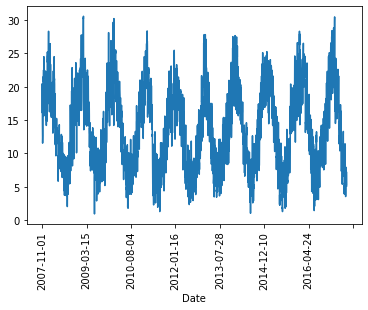

In [18]:
# Seleccionar una ciudad, ej. Canberra y graficar sus temperaturas medias en el tiempo

dfc=df[df['Location']=='Canberra'].copy()
dfc.set_index('Date',inplace=True) #Indexar por fecha
dfc['MedTemp'].plot(rot=90) #Graficar temperatura media, rotar etiquetas

Nuestra red RNN recibe secuencias de 7 dias para realizar la prediccion del siguiente día, es necesario convertir los datos a una serie de secuencias de 7 días y asociar cada serie de 7 dias a su siguiente valor.

In [19]:
# Autor:
# https://towardsdatascience.com/rnn-recurrent-neural-networks-how-to-successfully-model-sequential-data-in-python-5a0b9e494f92

def prep_data(datain, time_step):
    y_indices = np.arange(start=time_step, stop=len(datain), step=time_step)
    y_tmp = datain[y_indices]
    rows_X = len(y_tmp)
    X_tmp = datain[range(time_step*rows_X)]
    X_tmp = np.reshape(X_tmp, (rows_X, time_step, 1))
    return X_tmp, y_tmp


In [20]:
# Agregamos un eje a los datos para que las temperaturas sean una columna
temp = dfc['MedTemp'].values.reshape(-1, 1)

# Escalamiento
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(temp)

# Visualizando los datos escalados
X

array([[0.51351351],
       [0.65878378],
       [0.59459459],
       ...,
       [0.14358108],
       [0.21283784],
       [0.1402027 ]])

## Creación de conjuntos de training y test.

Ojo aquí, Sklearn cuenta con un método para hacer split para series de tiempo (Time Series Split) que es más correcto utilizar ya que no mezcla períodos de training y test.  Si utilizas el método normal de "train_test_split" puedes utilizar implícitamente algunos datos del futuro en tu entrenamiento, lo cual es un errór metodológico conocido como "future leakage"


In [21]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

for train_index, test_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  training_set, test_set = X[train_index], X[test_index]


TRAIN: [   0    1    2 ... 1141 1142 1143] TEST: [1144 1145 1146 ... 2283 2284 2285]
TRAIN: [   0    1    2 ... 2283 2284 2285] TEST: [2286 2287 2288 ... 3425 3426 3427]


In [22]:
len(training_set), len(test_set)

(2286, 1142)

In [23]:
## Preparar los arreglos de input utilizando la funcion previa para producir 
## secuencias de 7 timesteps 

time_step = 7
X_train, y_train = prep_data(training_set, time_step)
X_test, y_test = prep_data(test_set, time_step)

In [24]:
# Ejemplo de lo que pasaremos a nuestra red RNN para entrenar
# Una secuencia de 7 dias y un ejemplo del siguiente valor

X_train[0], y_train[0]

(array([[0.51351351],
        [0.65878378],
        [0.59459459],
        [0.45439189],
        [0.36824324],
        [0.35810811],
        [0.37837838]]), array([0.39527027]))

## Creación de la RNN con Keras

In [25]:
##### Step 4 - Specify the structure of a Neural Network

from keras.models import Sequential
from keras.layers import Input, Dense, SimpleRNN

model = Sequential() 
model.add(Input(shape=(time_step,1))) #Se especifica la forma del input 7x1
model.add(SimpleRNN(units=1, activation='tanh')) #Capa recurrente de 1 neurona
model.add(Dense(units=1, activation='tanh')) 
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_squared_error')

In [26]:
model.fit(X_train, y_train, batch_size=1, epochs=20, validation_split=0.2)

Epoch 1/20
260/260 [==============================] - 2s 4ms/step - loss: 0.1247 - val_loss: 0.0141
Epoch 2/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0135 - val_loss: 0.0125
Epoch 3/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 4/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 5/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0106 - val_loss: 0.0114
Epoch 6/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0120
Epoch 7/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 8/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 9/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0108
Epoch 10/20
260/260 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0128

In [27]:
##### Step 7 - Use model to make predictions
# Predict the result on training data
pred_train = model.predict(X_train)
# Predict the result on test data
pred_test = model.predict(X_test)

## Evaluación del modelo

El siguiente código nos ayudará a entender la calidad de las predicciones de nuestro modelo, para ello utilizaremos la métrica MAPE o error medio absoluto porcentual, ya que es más informativo que el MSE al momento de evaluar los pronósticos de los modelos. También imprimiremos MSE, sin embargo, dado que nuestras unidades estan escaladas es de poca ayuda a la interpretación.

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

##### Evaluacion del modelo
print("")
print('-------------------- Resumen --------------------')
model.summary() 
print("")
print('-------------------- Parámetros del modelo --------------------')
print("El último parámetro de cada capa es el sesgo y los demás son pesos")
print("")
for layer in model.layers:
    print(layer.name)
    for item in layer.get_weights():
        print("  ", item)
print("")
print('---------- Evaluación en los datos de entrenamiento ----------')
print("MSE: ", mean_squared_error(y_train, pred_train))
print("MAPE: ", mean_absolute_percentage_error(y_train, pred_train))
print("")

print('---------- Evaluación en los datos de test ----------')
print("MSE: ", mean_squared_error(y_test, pred_test))
print("MAPE: ", mean_absolute_percentage_error(y_test, pred_test))


-------------------- Resumen --------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1)                 3         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________

-------------------- Parámetros del modelo --------------------
El último parámetro de cada capa es el sesgo y los demás son pesos

simple_rnn_1
   [[-0.7973412]]
   [[0.59985405]]
   [0.0237112]
dense_2
   [[-0.9256004]]
   [-0.09983439]
dense_3
   [[1.2881272]]
   [-0.0

Mediante la métrica MAPE podemos ver que en promedio, el error porcentual de nuestra predicción en los datos conocidos por el modelo (training) es de 24% y en los no conocidos (test) es de 37%.  Si bien estos resultados no son impresionantes y sin duda pueden mejorarse, cumplen el objetivo de mostrar cómo modelar series de tiempo con RNN.

## Visualizacion de resultados

Para visualizar los resultados es necesario realizar la transformación de escalado de forma inversa y graficar, aquí puedes ver cómo modelamos una serie sencilla utilizando una RNN.

In [29]:
plot_y=scaler.inverse_transform(y_test)
plot_y_pred=scaler.inverse_transform(pred_test)


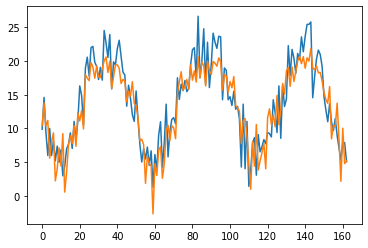

In [30]:
import matplotlib.pyplot as plt

plt.plot(plot_y)
plt.plot(plot_y_pred)
